In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.autograd import Variable
import numpy as np
import random

from RunningEnv import EnvWrapper
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns


In [51]:
#discount factor for future utilities
DISCOUNT_FACTOR = 0.99

#number of episodes to run
NUM_EPISODES = 1000

#max steps per episode
MAX_STEPS = 10000

#device to run model on 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

FRAMES = 500
pref_pace = 181
target_pace = pref_pace*1.1

In [52]:
#Using a neural network to learn our policy parameters
class PolicyNetwork(nn.Module):
    
    #Takes in observations and outputs actions
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.name = "NN"
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, action_space)
    
    #forward pass
    def forward(self, x):
        #input states
        x = self.input_layer(x)
        
        #relu activation
        x = F.relu(x)
        
        #actions
        actions = self.output_layer(x)
        
        #get softmax for a probability distribution
        action_probs = F.softmax(actions, dim=1)
        
        return action_probs

class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.name = "LSTM"
        self.num_classes = num_classes  # number of classes
        self.num_layers = num_layers  # number of layers
        self.input_size = input_size  # input size
        self.hidden_size = hidden_size  # hidden state
        self.seq_length = seq_length  # sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)  # lstm
        self.fc_1 = nn.Linear(hidden_size, 128)  # fully connected 1
        self.fc = nn.Linear(128, num_classes)  # fully connected last layer

        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))  # hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))  # internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0))  # lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size)  # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out)  # first Dense
        out = self.relu(out)  # relu
        actions = self.fc(out)  # Final Output

        # #get softmax for a probability distribution
        action_probs = F.softmax(actions, dim=1)

        return action_probs


In [53]:
def select_action(network, state):
    ''' Selects an action given current state
    Args:
    - network (Torch NN): network to process state
    - state (Array): Array of action space in an environment

    Return:
    - (int): action that is selected
    - (float): log probability of selecting that action given state and network
    '''

    # convert state to float tensor, add 1 dimension, allocate tensor on device
    state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
    if network.name == "LSTM":
        state = torch.reshape(state, (state.shape[0], 1, state.shape[1]))

    # use network to predict action probabilities
    action_probs = network(state)

    # sample an action using the probability distribution
    m = Categorical(action_probs)
    action = m.sample()

    # return action
    return action.item(), m.log_prob(action)

In [54]:
#Make environment
env = EnvWrapper(pref_pace, target_pace)

# Network variables
input_size = 1 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 5 #number of output classes

#Init network
network_NN = PolicyNetwork(input_size, num_classes).to(DEVICE)
network_LSTM = LSTM1(num_classes, input_size, hidden_size, num_layers, 1).to(DEVICE)

#Init optimizer
optimizer_NN = optim.Adam(network_NN.parameters(), lr=1e-2)
optimizer_LSTM = optim.Adam(network_LSTM.parameters(), lr=0.001)

In [55]:
def get_agent_score(network):
    env.reset()
    env.step(0)
    scores = []

    for _ in range(50):
        env.reset()
        state = env.step(0)[0]
        score = 0
        time_step = 0
        while env.steps < FRAMES:
            if network.name == "LSTM1":
                state = torch.from_numpy(state)
                state = state.type('torch.FloatTensor')
                hidden = network.init_hidden(1)
                output=network(state.unsqueeze(0), hidden)
                action=(output.argmax()).item()
            else:
                action, _ = select_action(network, state)
            new_state, reward, done = env.step(action)
            score += reward
            state = new_state
            if action > 0:
                time_step = time_step + env.times[action]
            else:
                time_step = time_step + 1
        scores.append(score)
    return np.array(scores).mean()

In [56]:
# track scores
scores_NN = []
avg_scores_NN = []


In [57]:
for network, optimizer, scores, avg_scores in zip([network_NN],[optimizer_NN],[scores_NN],[avg_scores_NN]):
    # iterate through episodes
    for episode in tqdm(range(2000)):

        # reset environment, initiable variables
        env.reset()
        state = env.step(0)[0]
        rewards = []
        log_probs = []
        score = 0

        # generate episode
        while env.steps < FRAMES:
            # env.render()

            # select action
            action, lp = select_action(network, state)

            # execute action
            new_state, reward, done = env.step(action)

            # track episode score
            score += reward

            # store reward and log probability
            rewards.append(reward)
            log_probs.append(lp)

            # end episode
            if done:
                break

            # move into new state
            state = new_state

        # append score
        scores.append(score)

        # Calculate Gt (cumulative discounted rewards)
        discounted_rewards = []

        # track cumulative reward
        total_r = 0

        # iterate rewards from Gt to G0
        for r in reversed(rewards):
            # Base case: G(T) = r(T)
            # Recursive: G(t) = r(t) + G(t+1)^DISCOUNT
            total_r = r + (np.sign(total_r) * (np.abs(total_r)) ** DISCOUNT_FACTOR)

            # append to discounted rewards
            discounted_rewards.append(total_r)

        # reverse discounted rewards
        rewards = torch.tensor(discounted_rewards).to(DEVICE)
        rewards = torch.flip(rewards, [0])

        # adjusting policy parameters with gradient ascent
        loss = []
        for r, lp in zip(rewards, log_probs):
            # we add a negative sign since network will perform gradient descent and we are doing gradient ascent with REINFORCE
            loss.append(-r * lp)

        # Backpropagation
        optimizer.zero_grad()
        sum(loss).backward()
        optimizer.step()

        if (((episode+1)%150) == 0):
            avg_scores = np.append(avg_scores, get_agent_score(network))

  0%|          | 0/2000 [00:00<?, ?it/s]

#### DQRN:

In [60]:
class model(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(model, self).__init__()
        self.name = "LSTM1"
        self.num_classes = num_classes  # number of classes
        self.num_layers = num_layers  # number of layers
        self.input_size = input_size  # input size
        self.hidden_size = hidden_size  # hidden state
        self.seq_length = seq_length  # sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)  # lstm
        self.fc_1 = nn.Linear(hidden_size, 128)  # fully connected 1
        self.fc = nn.Linear(128, num_classes)  # fully connected last layer

        self.relu = nn.ReLU()

    def init_hidden(self, batch_size):
        return [torch.zeros(self.num_layers, batch_size, self.hidden_size), Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size))]

    def forward(self, x, hidden):
        x = torch.reshape(x, (x.shape[0], 1, x.shape[1]))
        output, (hn, cn) = self.lstm(x, (hidden[0], hidden[1]))  # lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size)  # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out)  # first Dense
        out = self.relu(out)  # relu
        actions = self.fc(out)  # Final Output

        return actions


env.reset()

policy=model(num_classes, input_size, hidden_size, num_layers, 1)
target_net=model(num_classes, input_size, hidden_size, num_layers, 1)
target_net.load_state_dict(policy.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy.parameters())
criterion = F.smooth_l1_loss

memory=10000
store=[[dict()] for i in range(memory)]
gamma=0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200


def addEpisode(ind,prev,curr,reward,act):
    if len(store[ind]) ==0:
        store[ind][0]={'prev':prev,'curr':curr,'reward':reward,'action':act}
    else:
        store[ind].append({'prev':prev,'curr':curr,'reward':reward,'action':act})

def trainNet(total_episodes):
    if total_episodes==0:
        return
    ep=random.randint(0,total_episodes-1)
    if len(store[ep]) < 8:
        return
    else:
        start=random.randint(1,len(store[ep])-1)
        length=len(store[ep])
        inp=[]
        target=[]
        rew=torch.Tensor(1,length-start)
        actions=torch.Tensor(1,length-start)

        for i in range(start,length,1):
            inp.append((store[ep][i]).get('prev'))
            target.append((store[ep][i]).get('curr'))
            rew[0][i-start]=store[ep][i].get('reward')
            actions[0][i-start]=store[ep][i].get('action')
        targets = torch.Tensor(target[0].shape[0],target[0].shape[1])
        torch.cat(target, out=targets)
        ccs=torch.Tensor(inp[0].shape[0],inp[0].shape[1])
        torch.cat(inp, out=ccs)
        hidden = policy.init_hidden(length-start)
        qvals= target_net(targets,hidden)
        actions=actions.type('torch.LongTensor')
        actions=actions.reshape(length-start,1)
        hidden = policy.init_hidden(length-start)
        inps=policy(ccs,hidden).gather(1,actions)
        p1,p2=qvals.detach().max(1)
        targ = torch.Tensor(1,p1.shape[0])
        for num in range(start,length,1):
            if num==len(store[ep])-1:
                targ[0][num-start]=rew[0][num-start]
            else:
                targ[0][num-start]=rew[0][num-start]+gamma*p1[num-start]
        optimizer.zero_grad()
        inps=inps.reshape(1,length-start)
        loss = criterion(inps,targ)
        loss.backward()
        for param in policy.parameters():
            param.grad.data.clamp(-1,1)
        optimizer.step()

def trainDRQN(episodes):
    global scores_LSTM, avg_scores_LSTM
    steps_done=0
    for i in tqdm(range(0,episodes,1)):
        # print("Episode",i)
        env.reset()
        prev=env.step(0)[0]
        prev = torch.from_numpy(prev)
        prev = prev.type('torch.FloatTensor')
        done=False
        steps=0
        rew=0
        while env.steps < FRAMES:
            steps+=1
            hidden = policy.init_hidden(1)
            output=policy(prev.unsqueeze(0), hidden)
            action=(output.argmax()).item()
            rand= random.uniform(0,1)
            if rand < 0.05:
                action=random.randint(0,4)
            sc,reward,done = env.step(action)

            sc = torch.from_numpy(sc)
            sc = sc.type('torch.FloatTensor')
            reward = torch.from_numpy(reward)
            reward = reward.type('torch.FloatTensor')
            done = torch.from_numpy(done)
            done = done.type('torch.FloatTensor')

            rew=rew+reward
            addEpisode(i,prev.unsqueeze(0),sc.unsqueeze(0),reward,action)
            trainNet(i)
            prev=sc
            steps_done+=1
        scores_LSTM = np.append(scores_LSTM, rew)
        if i%10==0:
            target_net.load_state_dict(policy.state_dict())
        if (((episode+1)%150) == 0):
            avg_scores_LSTM = np.append(avg_scores_LSTM, get_agent_score(policy))


In [61]:
scores_LSTM = []
avg_scores_LSTM = []

In [62]:
trainDRQN(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [66]:
# get_agent_score(policy)
get_agent_score(network_NN)

5067.445240619999

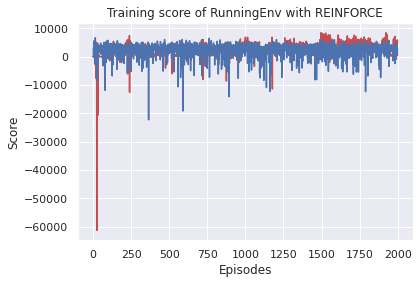

In [64]:
sns.set()

plt.plot(scores_NN, color='r')
plt.plot(scores_LSTM, color='b')
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.title('Training score of RunningEnv with REINFORCE')

# reg = LinearRegression().fit(np.arange(len(avg_scores_NN)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
# reg = LinearRegression().fit(np.arange(len(avg_scores_LSTM)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
# y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
# plt.plot(y_pred)
plt.show()

#### Trying Agent:

In [19]:
done = False
env.reset()
state = env.step(0)[0]
try_scores = []

for _ in tqdm(range(50)):
    env.reset()
    state = env.step(0)[0]
    done = False
    score = 0
    time_step = 0
    while env.steps < FRAMES:
        # env.render()
        action, lp = select_action(network_LSTM, state)
        new_state, reward, done = env.step(action)
        score += reward
        state = new_state
        if action > 0:
            time_step = time_step + env.times[action]
        else:
            time_step = time_step + 1
    try_scores.append(score)

  0%|          | 0/50 [00:00<?, ?it/s]

In [20]:
np.array(try_scores).mean()

1824.8522646302563

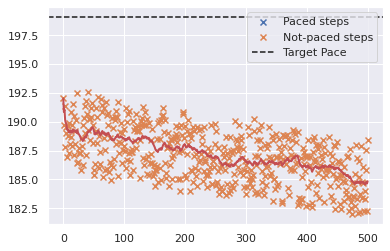

-34359.42394401336


In [70]:
env.reset()
state = env.step(0)[0]

while env.steps < FRAMES:
    # action, _ = select_action(network, state)

    #
    state = torch.from_numpy(state)
    state = state.type('torch.FloatTensor')
    hidden = policy.init_hidden(1)
    output=policy(state.unsqueeze(0), hidden)
    action=(output.argmax()).item()
    #
    new_state, reward, done = env.step(action)
    # if reward < 0:
    #     print(action, state, new_state, reward)
    # if action == 0:
    #     # print(action, (state+1)*pref_pace, (new_state+1)*pref_pace, reward)
    #     print(action, state, new_state, reward)
    state = new_state

x = np.linspace(0, len(env.env_pacing), len(env.env_pacing))
plt.scatter(x[np.array(env.env_pacing)==1], np.array(env.pace)[np.array(env.env_pacing)==1], marker="x", label='Paced steps')
plt.scatter(x[np.array(env.env_pacing)==0], np.array(env.pace)[np.array(env.env_pacing)==0], marker="x", label='Not-paced steps')


# plt.scatter(x[np.array(env_pacing)==1], np.array(pace)[np.array(env_pacing)==1], marker="x", label='Paced steps')
# plt.scatter(x[np.array(env_pacing)==0], np.array(pace)[np.array(env_pacing)==0], marker="x", label='Not-paced steps')

# plt.scatter(x[np.array(pacing)==1], np.array(pacing)[np.array(pacing)==1]*181, color='r', marker="x")
plt.axhline(y=target_pace, color='k', linestyle='--', label='Target Pace')

plt.plot(x, env.state_traj, 'r-', linewidth=2)
plt.legend()
plt.show()

print(np.sum(env.rewards))

### Trying Heuristic agent

In [13]:
class HeuristicAgent:
    def __init__(self):
        self.initial_wait = 20
        self.initial_completed = False

    def select_action(self, state):
        avg_pace = state[0]
        action = 0

        # Initial waiting time
        if not(self.initial_completed):
            self.initial_wait = self.initial_wait - 1
            if self.initial_wait == 0:
                self.initial_completed = True

        if abs(avg_pace) > 27e-3:
            action = 4

        elif abs(avg_pace) > 22e-3:
            action = 3

        elif abs(avg_pace) > 15e-3:
            action = 2

        elif abs(avg_pace) > 11e-3:
            action = 1

        return action

In [14]:
heuristic_agent = HeuristicAgent()
print(heuristic_agent.select_action([0.014]))

1


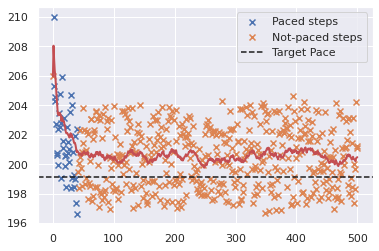

4831.2600423597405


In [15]:
heuristic_agent = HeuristicAgent()
env.reset()
state = env.step(0)[0]

while env.steps < FRAMES:
    action = heuristic_agent.select_action(state)
    new_state, reward, _ = env.step(action)
    # if action != 0:
    #     print(action, state, new_state, reward)
    state = new_state

x = np.linspace(0, len(env.env_pacing), len(env.env_pacing))
plt.scatter(x[np.array(env.env_pacing)==1], np.array(env.pace)[np.array(env.env_pacing)==1], marker="x", label='Paced steps')
plt.scatter(x[np.array(env.env_pacing)==0], np.array(env.pace)[np.array(env.env_pacing)==0], marker="x", label='Not-paced steps')


# plt.scatter(x[np.array(env_pacing)==1], np.array(pace)[np.array(env_pacing)==1], marker="x", label='Paced steps')
# plt.scatter(x[np.array(env_pacing)==0], np.array(pace)[np.array(env_pacing)==0], marker="x", label='Not-paced steps')

# plt.scatter(x[np.array(pacing)==1], np.array(pacing)[np.array(pacing)==1]*181, color='r', marker="x")
plt.axhline(y=target_pace, color='k', linestyle='--', label='Target Pace')

plt.plot(x, env.state_traj, 'r-', linewidth=2)
plt.legend()
plt.show()

print(np.sum(env.rewards))

In [16]:
done = False
env.reset()
state = env.step(0)[0]
heuristic_agent = HeuristicAgent()
scores_heuristic = []

for _ in tqdm(range(50)):
    env.reset()
    state = env.step(0)[0]
    done = False
    score = 0

    while env.steps < FRAMES:
        # env.render()
        action = heuristic_agent.select_action(state)
        new_state, _, _ = env.step(action)
        state = new_state
        score += reward
    scores_heuristic.append(score)

  0%|          | 0/50 [00:00<?, ?it/s]

In [17]:
print(np.mean(scores_heuristic))

4312.6


### Play manually

In [18]:
env.reset()
state, reward, _ = env.step(0)
print(state, (state+1)*pref_pace, reward)


[-0.02894362] [175.76120518] [-7.62674301]


In [19]:
action= 0
new_state, reward, done = env.step(action)
print(action, state, new_state, reward)
state = new_state

0 [-0.02894362] [-0.04045412] [-30.54415578]


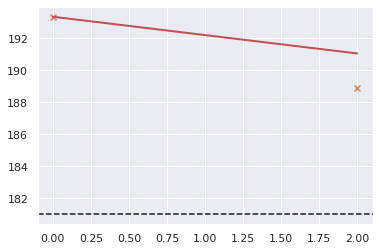

-38.17089878692485


In [20]:
x = np.linspace(0, len(env.env_pacing), len(env.env_pacing))
plt.scatter(x[np.array(env.env_pacing)==1], np.array(env.pace)[np.array(env.env_pacing)==1], marker="x", label='Paced steps')
plt.scatter(x[np.array(env.env_pacing)==0], np.array(env.pace)[np.array(env.env_pacing)==0], marker="x", label='Not-paced steps')


# plt.scatter(x[np.array(env_pacing)==1], np.array(pace)[np.array(env_pacing)==1], marker="x", label='Paced steps')
# plt.scatter(x[np.array(env_pacing)==0], np.array(pace)[np.array(env_pacing)==0], marker="x", label='Not-paced steps')

# plt.scatter(x[np.array(pacing)==1], np.array(pacing)[np.array(pacing)==1]*181, color='r', marker="x")
plt.axhline(y=181, color='k', linestyle='--', label='Target Pace')

plt.plot(x, env.state_traj, 'r-', linewidth=2)
plt.show()

print(np.sum(env.rewards))